<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emot

In [2]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Default GPU Device: /device:GPU:0
True
2.8.0
2.8.0


In [4]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## load software data

In [5]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [6]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


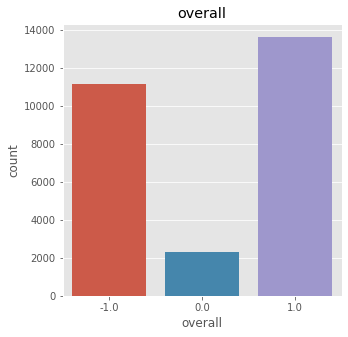

In [7]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


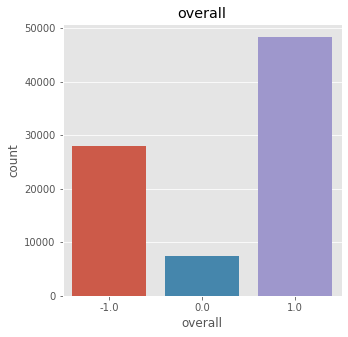

In [8]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


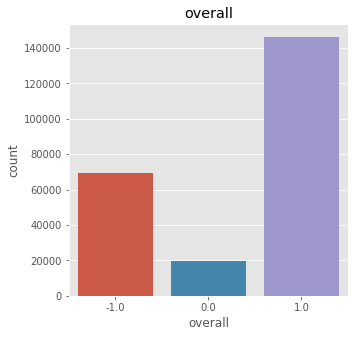

In [9]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


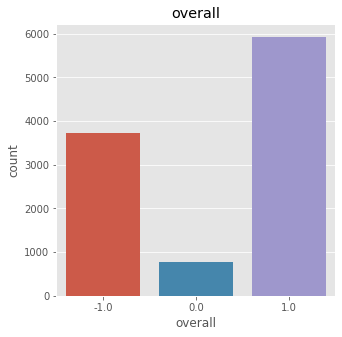

In [10]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5900 positive，3700 negative，770 neutral

80%(8056) training and 20%(2314) testing

In [11]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4480,:]
  train_neudata = neu.iloc[:616,:]
  train_negdata = neg.iloc[:2960,:]

  # split to get test for each class
  test_posdata = pos.iloc[4480:5900,:]
  test_neudata = neu.iloc[616:770,:]
  test_negdata = neg.iloc[2960:3700,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [12]:
# data for 1998 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [13]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [14]:
df1_train.head()

,overall,reviewTime,reviewText
20629,2.0,2002,It took a while to learn how the software work...
4162,1.0,2002,Final Draft has created the perfect word proce...
23932,2.0,2005,I found this product exasperating with it's co...
13050,2.0,2005,I bought this software to be able to download ...
217,2.0,2002,"I thought it was a good game but, it went too ..."


## Text Preprocessing

In [15]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [16]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [17]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [18]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [19]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
20629,2.0,2002,It took a while to learn how the software work...,took learn software works dont know italian fi...
4162,1.0,2002,Final Draft has created the perfect word proce...,final draft created perfect word processor con...
23932,2.0,2005,I found this product exasperating with it's co...,found product exasperating connection net pass...
13050,2.0,2005,I bought this software to be able to download ...,bought software able download financial inform...
217,2.0,2002,"I thought it was a good game but, it went too ...",thought good game went fast fun gave time lear...


In [20]:
df1_test.head()

,overall,reviewTime,reviewText,cleanText
23233,1.0,2006,I recently purchased this program and I was ab...,recently purchased program able use functions ...
21304,1.0,2003,We happen to develop Filemaker database system...,happen develop filemaker database systems cust...
9309,1.0,2006,I am a veteran screen printer and am kind of n...,veteran screen printer kind new graphic arts s...
2518,1.0,2002,I have been playing this game for about six ye...,playing game years tired puzzles extremely fun...
15822,1.0,2006,I think PC-Cillin is great security protection...,think pccillin great security protection computer


## Tokenization

In [21]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

29896 words are used
Training:
Average length of each row >> 68.93185203574976
Maximum length of each row >> 1328


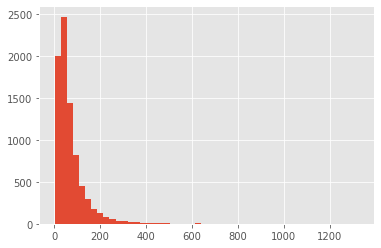

Testing
Average length of each row >> 67.35177182368193
Maximum length of each row >> 533


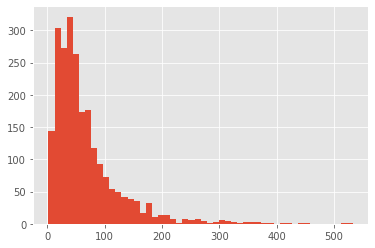

max sequence length:  1328


In [22]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

23561 words are used
Training:
Average length of each row >> 55.0791956305859
Maximum length of each row >> 975


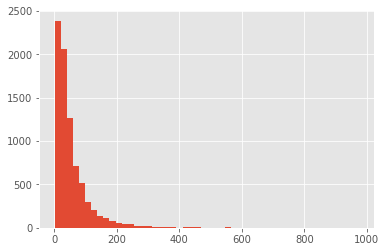

Testing
Average length of each row >> 51.24027657735523
Maximum length of each row >> 800


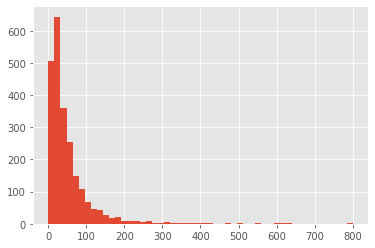

max sequence length:  975


In [23]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

14571 words are used
Training:
Average length of each row >> 27.564051638530287
Maximum length of each row >> 665


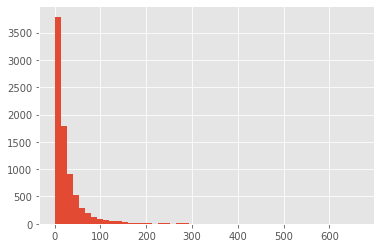

Testing
Average length of each row >> 24.460242005185826
Maximum length of each row >> 574


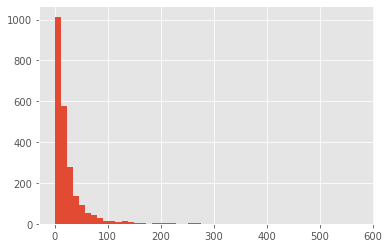

max sequence length:  665


In [24]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

11499 words are used
Training:
Average length of each row >> 16.862214498510426
Maximum length of each row >> 477


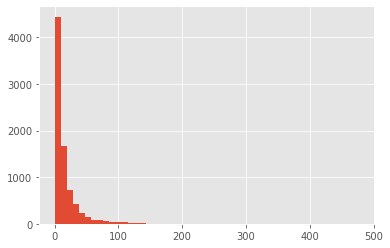

Testing
Average length of each row >> 15.621434745030252
Maximum length of each row >> 389


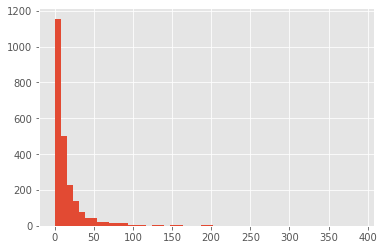

max sequence length:  477


In [25]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

## Padding

In [26]:
sequence_size = max(df1_maxlen,df2_maxlen,df3_maxlen,df4_maxlen)
print("max sequence length for software: ",sequence_size)

max sequence length for software:  1328


In [27]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

In [28]:
df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

In [29]:
df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

In [30]:
df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

## Build LSTM Model

In [31]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  29896


In [32]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [33]:
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

### For 1998-2006

In [34]:
# df1_lstm = bilstm_model()
# plot_model(df1_lstm)
# lstm_no_hist = df1_lstm.fit(df1_train_pad,df1_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_test_pad,df1_test_label),callbacks=[es])

In [35]:
# plt.plot(lstm_no_hist.history['loss'], label='loss')
# plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
# plt.legend()

In [36]:
# plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
# plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
# plt.legend()

In [37]:
# df1_lstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df1_BiLSTM.h5')

### For 2007-2012

In [38]:
# df2_lstm = bilstm_model()
# plot_model(df2_lstm)
# lstm_no_hist = df2_lstm.fit(df2_train_pad,df2_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_test_pad,df2_test_label),callbacks=[es])

In [39]:
# plt.plot(lstm_no_hist.history['loss'], label='loss')
# plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
# plt.legend()

In [40]:
# plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
# plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
# plt.legend()

In [41]:
# df2_lstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df2_BiLSTM.h5')

### For 2013-2017

In [42]:
# df3_lstm = bilstm_model()
# plot_model(df3_lstm)
# lstm_no_hist = df3_lstm.fit(df3_train_pad,df3_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_test_pad,df3_test_label),callbacks=[es])

In [43]:
# plt.plot(lstm_no_hist.history['loss'], label='loss')
# plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
# plt.legend()

In [44]:
# plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
# plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
# plt.legend()

In [45]:
# df3_lstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df3_BiLSTM.h5')

### For 2018

In [46]:
df4_lstm = bilstm_model()
plot_model(df4_lstm)
lstm_no_hist = df4_lstm.fit(df4_train_pad,df4_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df4_test_pad,df4_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1328, 100)         2989600   
                                                                 
 bidirectional (Bidirectiona  (None, 1328, 256)        234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 339968)            0         
                                                                 
 dense (Dense)               (None, 32)                10879008  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

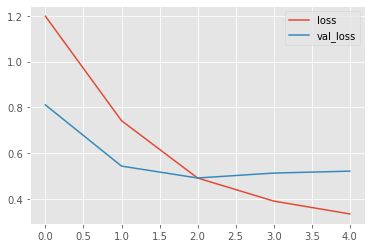

In [47]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

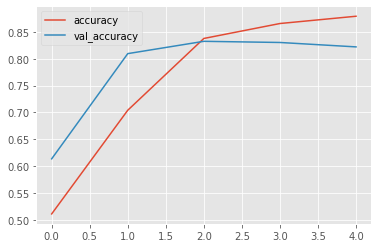

In [48]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [49]:
df4_lstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df4_BiLSTM.h5')

## Evaluate on other time data

### For 1998-2006

In [50]:
# df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df1_BiLSTM.h5')
# df1_model.evaluate(df2_test_pad,df2_test_label)

In [51]:
# df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df1_BiLSTM.h5')
# df1_model.evaluate(df3_test_pad,df3_test_label)

In [52]:
# df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df1_BiLSTM.h5')
# df1_model.evaluate(df4_test_pad,df4_test_label)

### For 2007-2012

In [53]:
# df2_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df2_BiLSTM.h5')
# df2_model.evaluate(df1_test_pad,df1_test_label)

In [54]:
# df2_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df2_BiLSTM.h5')
# df2_model.evaluate(df3_test_pad,df3_test_label)

In [55]:
# df2_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df2_BiLSTM.h5')
# df2_model.evaluate(df4_test_pad,df4_test_label)

### For 2013-2017

In [56]:
# df3_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df3_BiLSTM.h5')
# df3_model.evaluate(df1_test_pad,df1_test_label)

In [57]:
# df3_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df3_BiLSTM.h5')
# df3_model.evaluate(df2_test_pad,df2_test_label)

In [58]:
# df3_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df3_BiLSTM.h5')
# df3_model.evaluate(df4_test_pad,df4_test_label)

### For 2018

In [59]:
df4_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df4_BiLSTM.h5')
df4_model.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 4s 46ms/step - loss: 1.6077 - accuracy: 0.5009


[1.6076658964157104, 0.5008643269538879]

In [60]:
df4_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df4_BiLSTM.h5')
df4_model.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 4s 48ms/step - loss: 1.5954 - accuracy: 0.5056


[1.5954010486602783, 0.5056179761886597]

In [61]:
df4_model = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/df4_BiLSTM.h5')
df4_model.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 4s 47ms/step - loss: 1.4600 - accuracy: 0.5229


[1.460045576095581, 0.5229040384292603]